# Training on data such that there are 175 events with n tracks for n in [1,25].
# Testing on the RAMP data

In [1]:
!nvidia-smi

Tue Aug 15 15:13:25 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.66                 Driver Version: 375.66                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:04:00.0     Off |                  N/A |
| 27%   29C    P8     9W / 180W |   1355MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:05:00.0     Off |                  N/A |
| 27%   31C    P8     9W / 180W |   7735MiB /  8114MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
# Author: Daniel Zurawski
# Author: Keshav Kapoor
# Organization: Fermilab
# Grammar: Python 3.6.1

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

### Choose either (1) or (2).
### (1) If you prefer a separate window for plots, uncomment the below.
#import matplotlib
#matplotlib.use('qt5agg')

### (2) If you prefer plots to display within the notebook, uncomment the below.
### WARNING: Plots suffer performance issues and will lag a bit.
%matplotlib notebook

import importlib
import keras # Neural network models
import pandas as pd # Data frames
import numpy as np  # numerical python
from tracker3d import loader, utils, metrics

Using Theano backend.
Using cuDNN version 5110 on context None
Mapped name None to device cuda: GeForce GTX 1080 (0000:0E:00.0)


**Loading Data From .csv Files**

In [3]:
order   = ("r", "phi", "z")
n_noise = 0
code    = (order[0][0] + order[1][0] + order[2][0]).upper()

# True if you want to load from .npz file. False if you want to create your own data.
# This will NOT load from any .npz file. It will only load from .npz files stored using the
# loader.to_file() function.
load_from_file = True

# Name of files to save/load train and target data to/from.
test_file  = "datasets/npz/RAMP-{0}-{1}N.npz".format(code, n_noise)  # Data to test models with.
train_file = "datasets/npz/UNIF-25T-175E-{0}-{1}N.npz".format(code, n_noise)  # Data to train models with.

# Name of .csv files to load train and target data from if you don't want to load from .npz file.
test_csv  = "datasets/raw/RAMP-Z.csv"
train_csv = "datasets/raw/UNIF-25T-175E.csv"

In [4]:
# Retrieve the data.
if load_from_file:  # Much faster than creating your own!
    test_data,  test_target  = loader.from_file(test_file)
    train_data, train_target = loader.from_file(train_file)
else:
    # If load_from_file is False, load the data from .csv files and then save the data to .npz files.
    train_data, train_target = loader.from_frame(
            frame=pd.read_csv(train_csv),
            order=order,
            n_noise=n_noise
    )
    
    permutation  = np.random.permutation(train_data.shape[0])
    train_data   = train_data[permutation]
    train_target = train_target[permutation]
    
    test_data, test_target = loader.from_frame(
            frame=pd.read_csv(test_csv),
            order=order,
            n_noise=n_noise,
            preferred_rows=train_target.shape[1],
            preferred_tracks=train_target.shape[2]
    )
    loader.to_file(train_data, train_target, train_file)
    loader.to_file(test_data, test_target, test_file)
    
print("Successfully loaded!")
print("train_data shape:   {0},\ntrain_target shape: {1}".format(train_data.shape, train_target.shape))
print("test_data shape:    {0},\ntest_target shape:  {1}".format(test_data.shape, test_target.shape))

Successfully loaded!
train_data shape:   (4375, 220, 3),
train_target shape: (4375, 220, 27)
test_data shape:    (3600, 220, 3),
test_target shape:  (3600, 220, 27)


In [5]:
# To be used when we define our model.
from keras.layers import TimeDistributed, Dense, LSTM, Activation
from keras.layers import Dropout, GRU, Bidirectional, Conv2D, Conv1D
from keras.layers import MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2, l1
from keras.models import Sequential

In [6]:
# It is time to define parameters for the model.
input_shape  = train_data.shape[1:] # Shape of an event.
num_classes  = train_target.shape[2] # Number of tracks per event
epochs       = 128
batch_size   = 64
valsplit     = 1/8
opt          = keras.optimizers.RMSprop(lr=0.001)

**The Model's Definition and Compilation**

In [7]:
model = keras.models.load_model("models/TRAIN-U25T175E-TEST-RAMP-RPZ-0N.h5")

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [ ]:
###############
# Input Layer #
###############
model = Sequential()
model.add(Dropout(rate=1/16, input_shape=input_shape))

#################
# Hidden Layers #
#################
for _ in range(3):
    model.add(Bidirectional(
        GRU(
            units=300, 
            return_sequences=True,
            recurrent_dropout=1/8,
            #activation="tanh",
            dropout=1/8,
            implementation=2
        ),
        merge_mode="concat"
    ))
################
# Output Layer #
################
model.add(TimeDistributed(Dense(
    units=num_classes,
    kernel_initializer="uniform", 
    activation="softmax"
)))

###############
# Compilation #
###############
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

# Print a summary of the model.
print("Epochs: {0}, Batch Size: {1}, Validation Split {2}%".format(
    epochs,
    batch_size,
    valsplit * 100
))
model.summary()

**Fitting the Model with the Uniform Data**

In [7]:
%%time

hist = model.fit (
    train_data,
    train_target,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_split=valsplit,
    callbacks=[keras.callbacks.ModelCheckpoint(
        filepath="models/TRAIN-U25T175E-TEST-RAMP-{0}-{1}N.h5".format(code, n_noise),
        period=4
    )]
)
model.save("models/TRAIN-U25T175E-TEST-RAMP-{0}-{1}N.h5".format(code, n_noise))

Train on 3828 samples, validate on 547 samples
Epoch 1/128
3828/3828 [==============================] - 60s - loss: 0.4004 - acc: 0.8467 - val_loss: 0.4460 - val_acc: 0.8339
Epoch 2/128
3828/3828 [==============================] - 59s - loss: 0.3987 - acc: 0.8474 - val_loss: 0.4598 - val_acc: 0.8297
Epoch 3/128
3828/3828 [==============================] - 59s - loss: 0.3916 - acc: 0.8494 - val_loss: 0.4555 - val_acc: 0.8322
Epoch 4/128
3828/3828 [==============================] - 59s - loss: 0.3930 - acc: 0.8494 - val_loss: 0.4521 - val_acc: 0.8315
Epoch 5/128
3828/3828 [==============================] - 60s - loss: 0.3900 - acc: 0.8503 - val_loss: 0.4471 - val_acc: 0.8350
Epoch 6/128
3828/3828 [==============================] - 60s - loss: 0.3895 - acc: 0.8507 - val_loss: 0.4479 - val_acc: 0.8329
Epoch 7/128
3828/3828 [==============================] - 60s - loss: 0.3886 - acc: 0.8514 - val_loss: 0.4855 - val_acc: 0.8209
Epoch 8/128
3828/3828 [==============================] - 60s - l

3828/3828 [==============================] - 60s - loss: 0.3025 - acc: 0.8866 - val_loss: 0.4463 - val_acc: 0.8488
Epoch 128/128
3828/3828 [==============================] - 60s - loss: 0.2957 - acc: 0.8883 - val_loss: 0.4413 - val_acc: 0.8476
CPU times: user 2h 5min 20s, sys: 3min 55s, total: 2h 9min 15s
Wall time: 2h 9min 11s


In [8]:
guesses = model.predict(test_data)

<IPython.core.display.Javascript object>


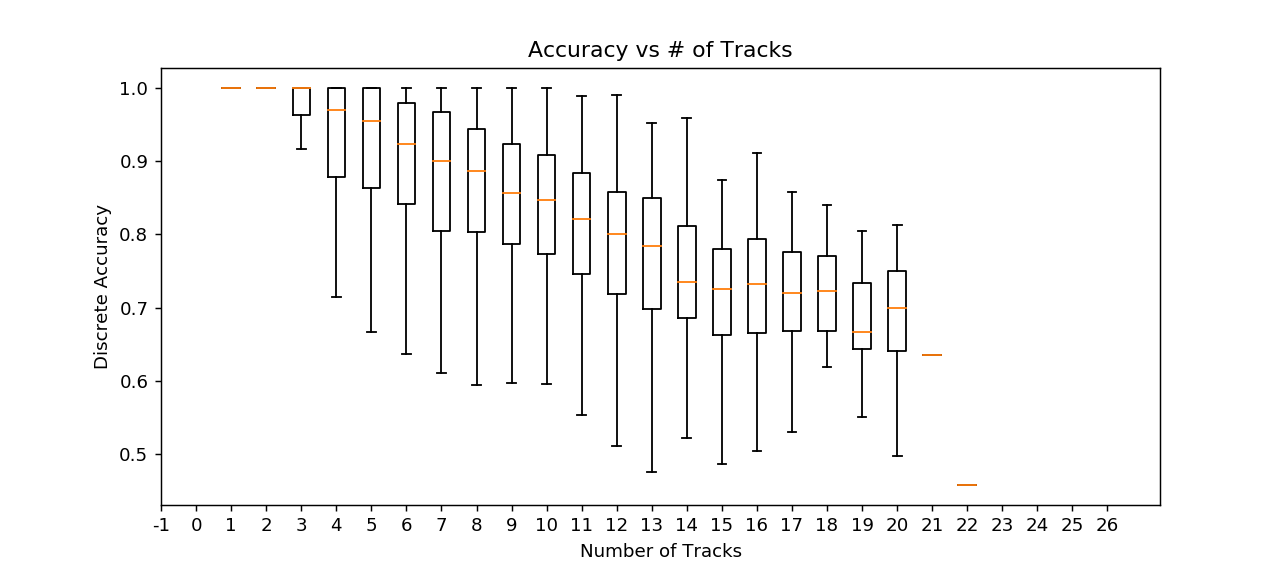

<IPython.core.display.Javascript object>


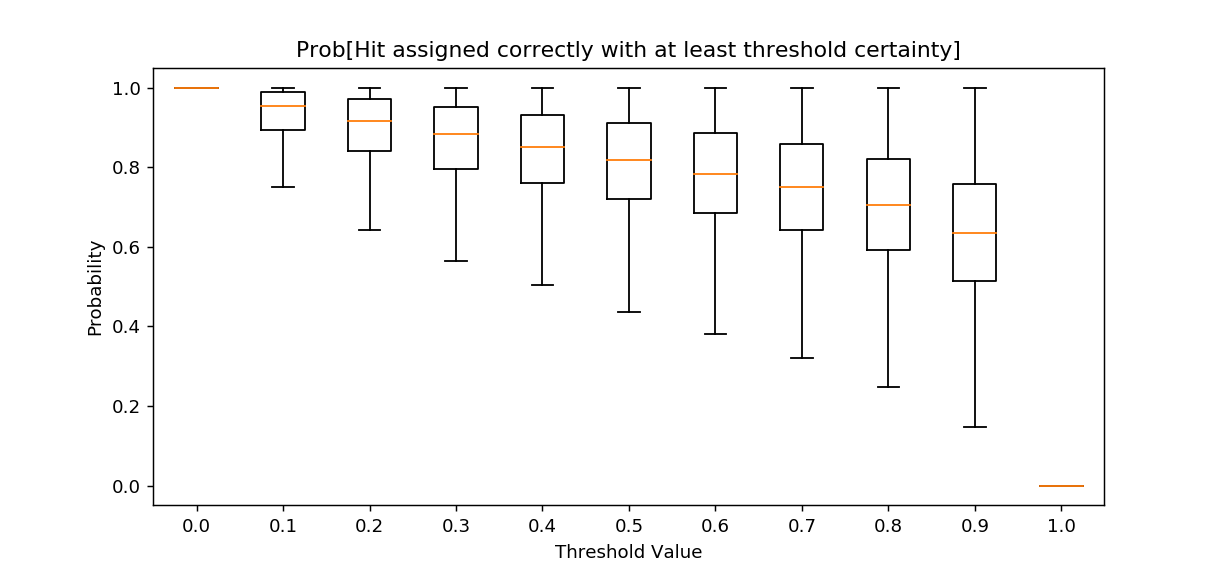

<IPython.core.display.Javascript object>


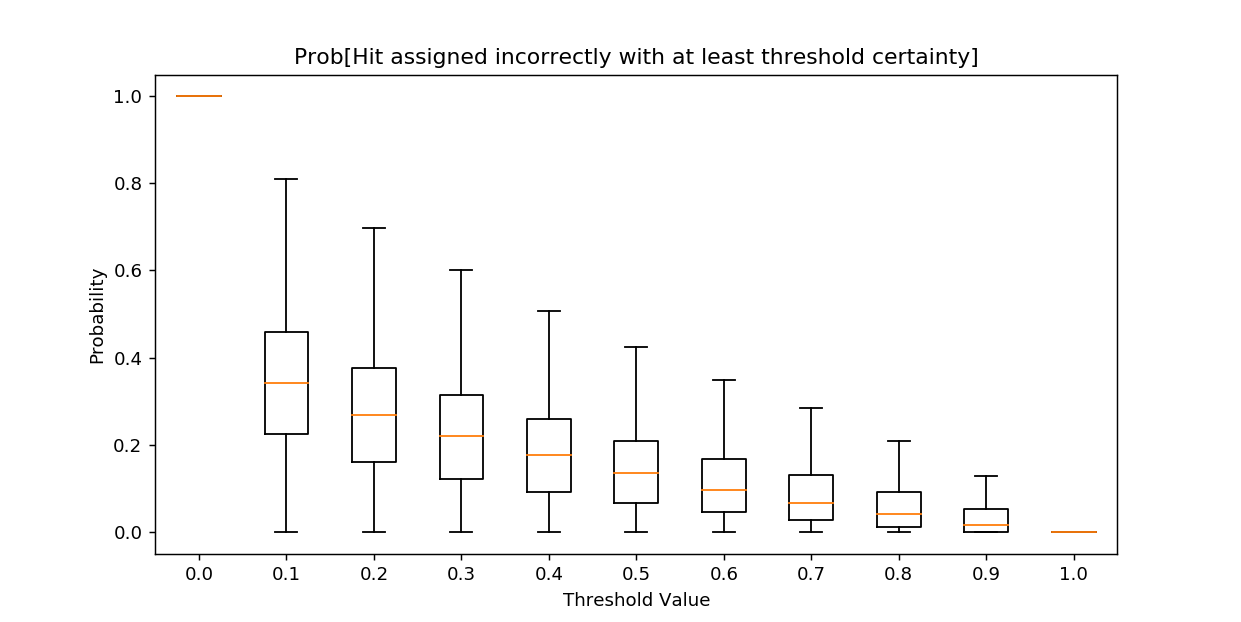

<IPython.core.display.Javascript object>


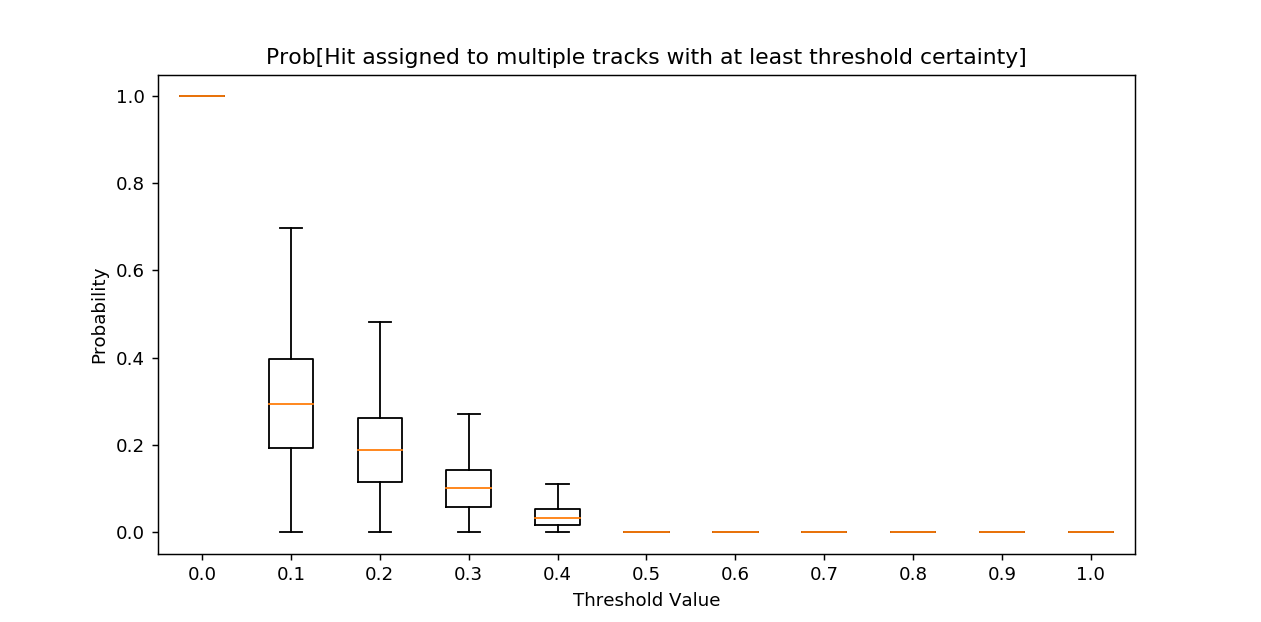

<IPython.core.display.Javascript object>


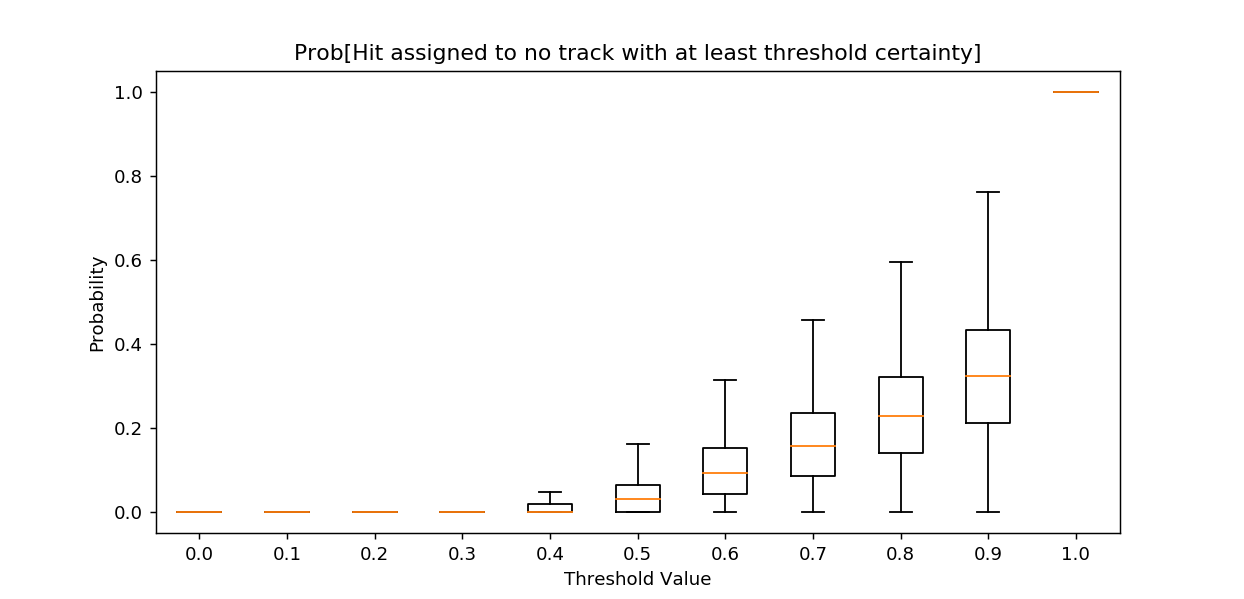

In [9]:
thresholds = [i / 10 for i in range(0, 1 + 10)]
_ = metrics.accuracy_vs_tracks_boxplot(guesses, test_target, noise=(n_noise > 0))
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="correct")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="incorrect")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="many")
_ = metrics.threshold_boxplot(guesses, test_target, thresholds, variation="none")

<IPython.core.display.Javascript object>


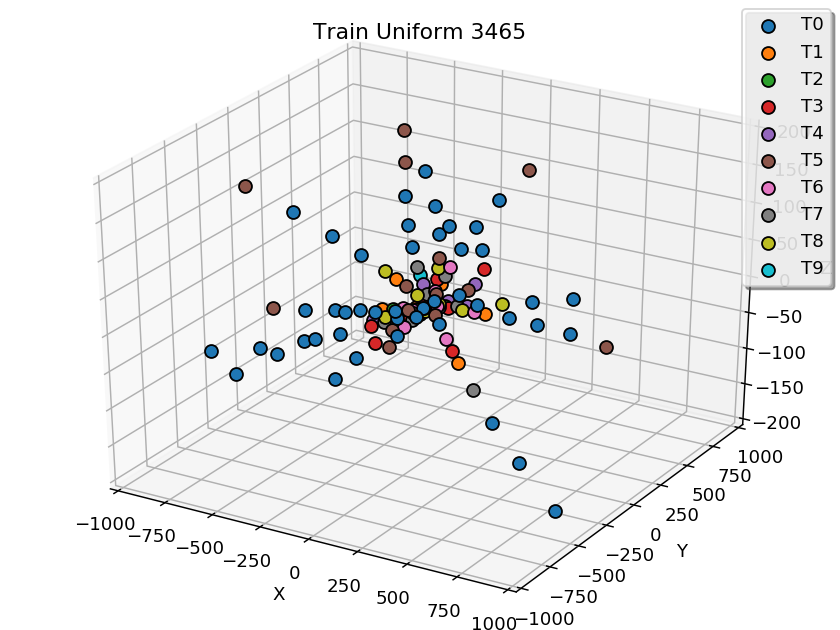

<IPython.core.display.Javascript object>


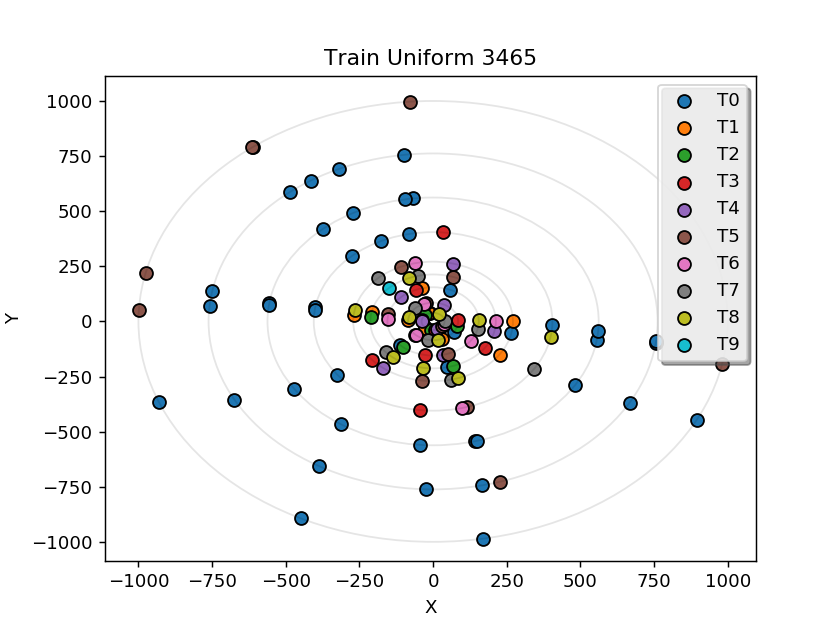

In [14]:
event_number = np.random.randint(train_data.shape[0])
plot = utils.plot3d(
    train_data[event_number],
    guesses[event_number],
    train_target[event_number],
    order=order,
    title="Train Uniform {}".format(event_number),
    flat_ax=None,
    has_noise=(n_noise > 0)
)
plot = utils.plot3d(
    train_data[event_number],
    guesses[event_number],
    train_target[event_number],
    order=order,
    title="Train Uniform {}".format(event_number),
    flat_ax="z",
    has_noise=(n_noise > 0)
)
#utils.display_side_by_side(train_data[event_number], train_target[event_number], order=order)